In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, accuracy_score


In [2]:
# Definir classes e diretório base
classes = ['ASC-H', 'ASC-US', 'HSIL', 'LSIL', 'Negative for intraepithelial lesion', 'SCC']
base_dir = ''  # Insira o caminho para o diretório base das imagens

# Coletar todos os endereços das imagens
all_image_paths = []
for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    for image_name in os.listdir(class_dir):
        if image_name.endswith('.png') or image_name.endswith('.jpg'):  # Filtrando por arquivos de imagem
            image_path = os.path.join(class_dir, image_name)
            all_image_paths.append((image_path, class_name))

# Função para carregar e pré-processar imagens
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    img_data = image.img_to_array(img)
    img_data = np.expand_dims(img_data, axis=0)
    img_data = preprocess_input(img_data)
    return img_data

# Carregar e pré-processar as imagens
X = []
y = []
for image_path, class_name in all_image_paths:
    img_data = load_and_preprocess_image(image_path)
    X.append(img_data)
    y.append(class_name)

X = np.vstack(X)
y = np.array(y)


{0: 2.0781981981981983, 1: 3.172167216721672, 2: 1.1287923272656097, 3: 1.4134803921568628, 4: 0.2835718149186212, 5: 11.939958592132506}
Epoch 1/70


c:\Users\Davi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


289/289 ━━━━━━━━━━━━━━━━━━━━ 115s 380ms/step - accuracy: 0.3715 - loss: 1.8735 - val_accuracy: 0.5839 - val_loss: 1.1322
Epoch 2/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 110s 376ms/step - accuracy: 0.5465 - loss: 1.2132 - val_accuracy: 0.6511 - val_loss: 0.9646
Epoch 3/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 110s 375ms/step - accuracy: 0.5955 - loss: 1.0289 - val_accuracy: 0.6225 - val_loss: 0.9964
Epoch 4/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 109s 373ms/step - accuracy: 0.6150 - loss: 1.0019 - val_accuracy: 0.6558 - val_loss: 0.9112
Epoch 5/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 109s 374ms/step - accuracy: 0.6464 - loss: 0.9546 - val_accuracy: 0.6823 - val_loss: 0.8581
Epoch 6/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 109s 373ms/step - accuracy: 0.6611 - loss: 0.9232 - val_accuracy: 0.6792 - val_loss: 0.8772
Epoch 7/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 109s 373ms/step - accuracy: 0.6613 - loss: 0.8685 - val_accuracy: 0.7187 - val_loss: 0.7661
Epoch 8/70
289/289 ━━━━━━━━━━━━━━━━━━━━ 109s 372ms/step - accuracy: 0.6665 - loss: 0.87

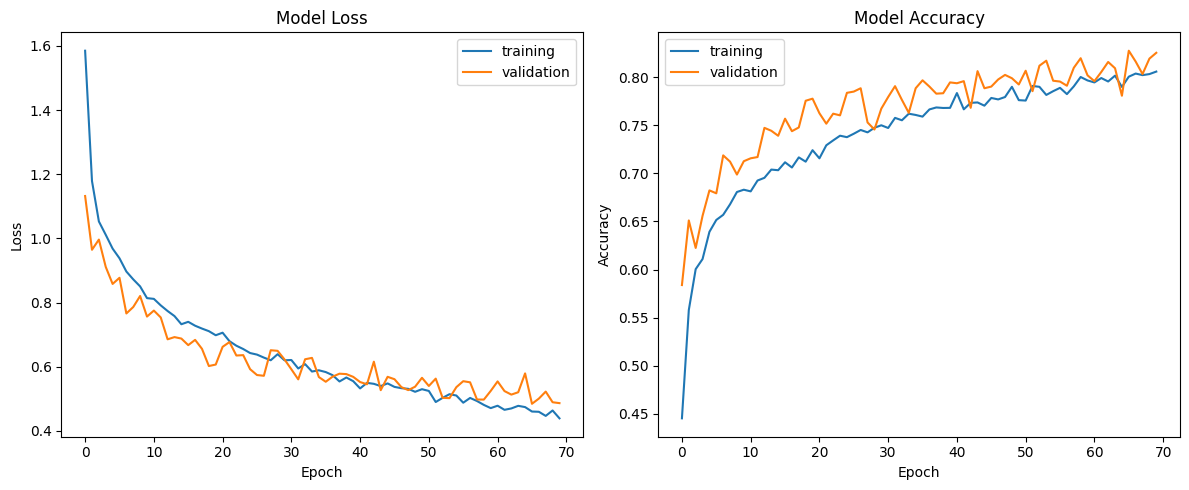

In [11]:
import os
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Codificar rótulos multiclasse
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=len(classes))

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=674310)

# Calcular pesos de classes
class_weights = class_weight.compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_encoded), 
    y=y_encoded
)
class_weights_dict = dict(enumerate(class_weights))
print(class_weights_dict)

# Carregar modelo ResNet50 pré-treinado e ajustar as últimas camadas
base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)  # Adicionando Dropout
predictions = Dense(len(classes), activation='softmax')(x)
model_multiclass = Model(inputs=base_model.input, outputs=predictions)

# Congelar as camadas convolucionais da ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Compilar o modelo
model_multiclass.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

# Adicionar Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Definir o gerador de dados com data augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2, 
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Ajustar o gerador de dados no conjunto de treinamento
datagen.fit(X_train)

# Treinar o modelo multiclasse com Early Stopping, data augmentation e class weights
history_multiclass = model_multiclass.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_test, y_test),
    epochs=70,
    callbacks=[early_stopping],
    class_weight=class_weights_dict
)

# Avaliar o modelo multiclasse
loss_multiclass, accuracy_multiclass = model_multiclass.evaluate(X_test, y_test)
print(f'Test accuracy (multiclass): {accuracy_multiclass}')

# Plotar os gráficos de perda e acurácia
def plot_history(history):
    plt.figure(figsize=(12, 5))

    # Plotar a perda
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='training')
    plt.plot(history.history['val_loss'], label='validation')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotar a acurácia
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='training')
    plt.plot(history.history['val_accuracy'], label='validation')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_history(history_multiclass)


73/73 ━━━━━━━━━━━━━━━━━━━━ 21s 279ms/step


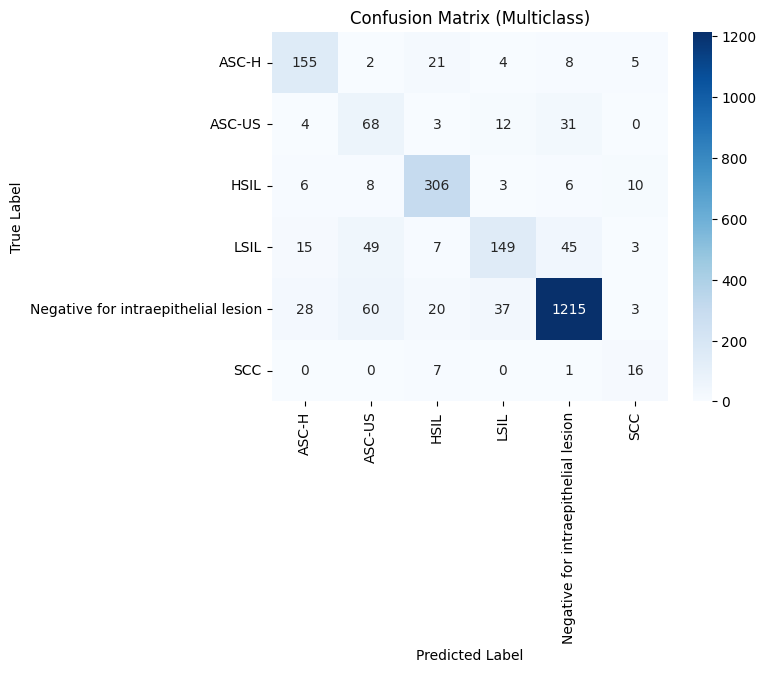

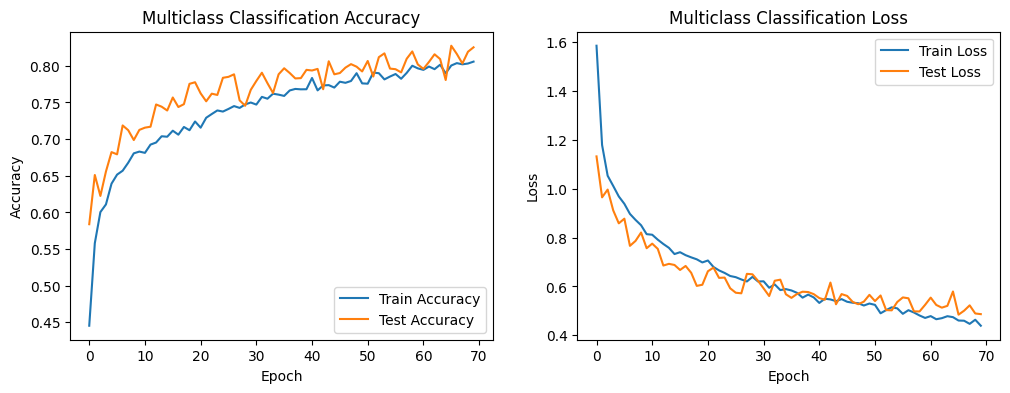

In [12]:
y_pred_multiclass = np.argmax(model_multiclass.predict(X_test), axis=1)

# Matriz de Confusão Multiclasse
conf_matrix_multiclass = confusion_matrix(np.argmax(y_test, axis=1), y_pred_multiclass)
sns.heatmap(conf_matrix_multiclass, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix (Multiclass)')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Gráficos de Aprendizado Multiclasse
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_multiclass.history['accuracy'], label='Train Accuracy')
plt.plot(history_multiclass.history['val_accuracy'], label='Test Accuracy')
plt.title('Multiclass Classification Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_multiclass.history['loss'], label='Train Loss')
plt.plot(history_multiclass.history['val_loss'], label='Test Loss')
plt.title('Multiclass Classification Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')  
plt.legend()

plt.show()

In [15]:
model_multiclass.save('modelo_profundo.h5')